In [95]:
# Summary -
# - There are totally 59K touch gestures.
# - Only ~22K (37%) touch gestures was clicked on a leaf element which had text content.
# - Created text dataset in the following format
#   - [[e11, e21, ... e1(MAX_TOKEN), e21, e22, ... e2(MAX_TOKEN), TARGET_TEXT],
#      ...
#     ]
#   - Vectorized the dataset.
# - Tried a simple classification model with a single hidden layer(1024).
#   - Accuracy on train data : 48%
#   - Accuracy on validation (20%) : 50%

In [96]:
# import statements.
import datetime
import glob
import json
import numpy as np
import os
import PIL
import tensorflow as tf
import re
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [97]:
# Constants.
LONG_TOUCH_THRESHOLD = 5
DIM_X = 1440
DIM_Y = 2560
MAX_TOKEN = 64
BATCH_SIZE = 10000
BUFFER_SIZE = 100
VOCAB_SIZE = 500
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
TRACES_PATH = 'filtered_traces/*/*'
NEGATIVE_SAMPLE_TARGET = '[null]'
PLACEHOLDER_TEXT = 'n/a'
y_true = []

In [98]:
# Gets all leaf nodes for a given element.
def get_leaf_nodes(element, leaf_nodes):
    if not element:
        return leaf_nodes
    if 'children' not in element:
        leaf_nodes.append(element)
        return leaf_nodes
    for child in element['children']:
        get_leaf_nodes(child, leaf_nodes)
    return leaf_nodes


def get_all_leaf_nodes(view_hierarchy_json):
    activity = view_hierarchy_json.get('activity')
    if not activity:
        return dataset
    root = activity.get('root')
    return get_leaf_nodes(root, [])


def get_target_text(leaf_nodes, x, y):
    target_text = None
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        if bounds[0] <= x and bounds[2] >= x and bounds[1] <= y and bounds[3] >= y:
            if 'text' in leaf_node:
                target_text = leaf_node['text'] or leaf_node.get('text-hint')
    return target_text


def get_leaf_node_texts(leaf_nodes):
    i = 1
    element_texts = []
    for leaf_node in leaf_nodes:
        if 'text' in leaf_node:
            text = leaf_node['text'] or leaf_node.get('text-hint')
            element_texts.append(str(text))
            i += 1
            if i == MAX_TOKEN:
                break
    return element_texts


# Identifies if a given gesture is a TOUCH gesture.
# In this task, we will only be focussing on TOUCH gestures.
def is_touch_gesture(gesture):
    if len(gesture) <= LONG_TOUCH_THRESHOLD:
        return True
    return False

In [99]:
dirs = glob.glob(TRACES_PATH)
touch_gesture_count = 0
non_touch_gesture_count = 0
for d in dirs:
  with open(f'{d}/gestures.json') as f:
    gestures = json.load(f)
    gestures = [gestures[x] for x in sorted(gestures, key=lambda x: int(x))]
    for gesture in gestures:
        if is_touch_gesture(gesture):
            touch_gesture_count += 1
        else:
            non_touch_gesture_count += 1
print('Number of touch gestures ', touch_gesture_count)
print('Number of non-touch gestures ', non_touch_gesture_count)

Number of touch gestures  59602
Number of non-touch gestures  6659


In [100]:
# Processes view hierarchies to construct dataset.
# Extract texts from MAX_TOKEN elements from both view hierarchies.
# Construct the dataset in the following format -
# [[e11, e21, ... e1(MAX_TOKEN), e21, e22, ... e2(MAX_TOKEN), TARGET_TEXT], ...]
def process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, is_positive_sample = True):
    if not view_hierarchy1 or not view_hierarchy2:
        return dataset
    
    trace_path = view_hierarchy1.split('view_hierarchies')[0]
    gesture_path = f'{trace_path}/gestures.json'
    with open(gesture_path) as file:
        gestures = json.load(file)

    with open(view_hierarchy1) as file:
        view_hierarchy1_json = json.load(file)
    with open(view_hierarchy2) as file:
        view_hierarchy2_json = json.load(file)
    
    if not view_hierarchy1_json or not view_hierarchy2_json:
        return dataset

    ui_number = view_hierarchy1.split('/')[-1].split('.')[0]
    gesture = gestures[ui_number]
    if not is_touch_gesture(gesture):
        return dataset
    
    if not len(gesture):
        return dataset
    x_cord = gesture[0][0]
    y_cord = gesture[0][1]
    x = x_cord * DIM_X
    y = y_cord * DIM_Y

    leaf_nodes1 = get_all_leaf_nodes(view_hierarchy1_json)
    leaf_nodes2 = get_all_leaf_nodes(view_hierarchy2_json)

    target_text = get_target_text(leaf_nodes1, x, y)
    if not target_text:
        return dataset
    
    screen1_element = get_leaf_node_texts(leaf_nodes1)
    screen2_element = get_leaf_node_texts(leaf_nodes2)

    for i in range(len(screen1_element), MAX_TOKEN):
        screen1_element.append(PLACEHOLDER_TEXT)
    for i in range(len(screen2_element), MAX_TOKEN):
        screen2_element.append(PLACEHOLDER_TEXT)

    if is_positive_sample:
        dataset.append(screen1_element + screen2_element)
        y_true.append(1)
    else:
        dataset.append(screen1_element + screen2_element)
        y_true.append(0)
        
    return dataset
        

def process_trace(trace_path, dataset):
    view_hierarchies_path = f'{trace_path}/view_hierarchies/*'
    view_hierarchies = sorted(glob.glob(view_hierarchies_path))
    for i in range(len(view_hierarchies) - 1):
        dataset = process_view_hierarchy(view_hierarchies[i], view_hierarchies[i+1], dataset)


def add_negative_samples(dataset):
    traces = sorted(glob.glob(TRACES_PATH))
    total_positive_samples = len(dataset)
    negative_samples_threshold = 1 * total_positive_samples
    negative_samples_counter = 0
    for i in range(len(traces) - 1):
        trace_path1 = traces[i]
        trace_path2 = traces[-i]
        view_hierarchies1_path = sorted(glob.glob(f'{trace_path1}/view_hierarchies/*'))
        view_hierarchies2_path = sorted(glob.glob(f'{trace_path2}/view_hierarchies/*'))
        for (view_hierarchy1, view_hierarchy2) in zip(view_hierarchies1_path, view_hierarchies2_path):
            dataset = process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, False)
            negative_samples_counter += 1
            if negative_samples_counter >= negative_samples_threshold:
                return dataset
    return dataset


dataset = []
for trace_path in sorted(glob.glob(TRACES_PATH)):
    process_trace(trace_path, dataset)

dataset = add_negative_samples(dataset)

In [101]:
# We create a custom standardization function to lowercase the text and 
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# Define the number of words in a sequence.
sequence_length = 1

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize=custom_standardization,
    output_mode='int',
    output_sequence_length=sequence_length)

all_words = []
for row in dataset:
    for word in row[:-1]:
        all_words.append(str(word))
unique_words = set(all_words)
print('unique_words = ',len(unique_words))
vectorize_layer.adapt(list(unique_words))

unique_words =  198807


In [102]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])
len(inverse_vocab)

['', '[UNK]', 'the', 'to', 'and', 'of', 'you', 'a', 'in', 'your', 'or', 'for', 'is', 'with', 'on', 'this', 'by', 'that', 'any', 'be']


123018

In [103]:
# Vectorize the data.
text_ds = tf.data.Dataset.from_tensor_slices(dataset)
text_vector_ds = text_ds.map(vectorize_layer)

In [104]:
sequences = list(text_vector_ds.as_numpy_iterator())
sequences = np.squeeze(sequences)

for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  125  8628   384  2367  8628   384  2367   383   383  2367 28400 34968
 13233 73848  2367  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370   207  1361   434   434   207    34   207    34
   207    34  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370  1370
  1370  1370  1370  1370  1370  1370  1370  1370] => ['settings', 'fancy', 'display', 'none', 'fancy', 'display', 'none', 'language', 'language', 'none', 'atrás', 'saltar', 'siguiente', 'settingsactivity', 'none', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'n

In [105]:
def map_to_dataset(sequences, inverse_vocab):
    num_ns = len(inverse_vocab)
    labels = []
    input_data = []
    for input_instance in sequences:
        y = input_instance[-1:]
        labels.append(y)
        input_data.append(input_instance[:-1])
#     categorized_labels = tf.keras.utils.to_categorical(labels, num_ns)
    return tf.data.Dataset.from_tensor_slices((input_data, labels))

In [128]:
y_true_reshaped = np.array(y_true).reshape(len(sequences), -1)
sequences_stack = np.hstack((sequences, y_true_reshaped))
train, test = train_test_split(sequences_stack, test_size=TEST_SIZE)
train, val = train_test_split(sequences_stack, test_size=VAL_SIZE)

In [129]:
BATCH_SIZE = 10000
TAKE_SIZE = 100000
train = map_to_dataset(train, inverse_vocab).take(TAKE_SIZE).batch(BATCH_SIZE)
val = map_to_dataset(val, inverse_vocab).take(TAKE_SIZE).batch(BATCH_SIZE)
test = map_to_dataset(test, inverse_vocab).take(TAKE_SIZE).batch(BATCH_SIZE)

In [130]:
model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(MAX_TOKEN*2, )),
    tf.keras.layers.Dense(128, name='Input', activation='relu'),
    tf.keras.layers.Dense(128, activation='relu', name='Hidden'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(1, activation='softmax', name='Softmax_Activation')
])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

history = model.fit(train, validation_data=val, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
3/3 [==============================] - 1s 300ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 2/10
3/3 [==============================] - 0s 56ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 4/10
3/3 [==============================] - 0s 69ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 5/10
3/3 [==============================] - 0s 55ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 6/10
3/3 [==============================] - 0s 57ms/step - loss: 0.5848 - binary_accuracy: 0.7284 - val_loss: 0.5774 - val_binary_accuracy: 0.7359
Epoch 7/10
3/3 [==============================] - 0s 52ms/step - loss: 0.5848 - b

In [109]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 128)               16512     
_________________________________________________________________
Hidden (Dense)               (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
Softmax_Activation (Dense)   (None, 1)                 129       
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


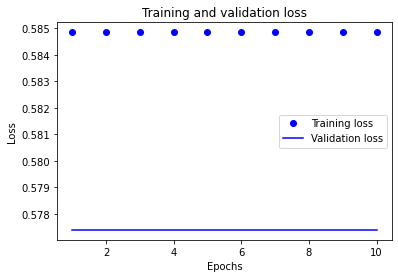

In [133]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
history_dict.keys()